In [ ]:
%%capture
!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
!pip install neuralforecast
!pip install datasetsforecast
!pip install hyperopt
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.2 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=299a8597ff526b5b880d4141179fff29ae6d53ad00f11331bab0642f7f17e2c6
  Stored in directory: /root/.cache/pip/wheels/5a/b5/4e/216953a1c711da55de29ed7ecf158b4a5bf32ef93d69ad66dd
Successfully built fugue-sql-antlr


In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# df = pd.read_csv("BIDV.csv", index_col="Date")
df = pd.read_csv("BIDV.csv")
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df = df.assign(unique_id=1.0)
df = df[['unique_id', 'ds', 'y']]
df.head(10)

,unique_id,ds,y
0,1.0,2019-03-01,23177.61914
1,1.0,2019-03-04,23706.78906
2,1.0,2019-03-05,24412.34766
3,1.0,2019-03-06,24518.18164
4,1.0,2019-03-07,24624.01563
5,1.0,2019-03-08,23989.01172
6,1.0,2019-03-11,23742.06641
7,1.0,2019-03-12,25047.34961
8,1.0,2019-03-13,25117.90625
9,1.0,2019-03-14,25541.24219


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  1251 non-null   float64       
 1   ds         1251 non-null   datetime64[ns]
 2   y          1251 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 29.4 KB


In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN

In [ ]:
%%capture
horizon = 12

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=500,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=2 * horizon,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='M')
# nf.fit(df=df, test_size=20)
nf.fit(df=df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 50.4 K
4 | context_adapter | Linear        | 62.4 K
5 | mlp_decoder     | MLP           | 769   
--------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.454     Total estimated model p

In [ ]:
import neuralforecast as nf

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df)
Y_hat_df = nf.predict().reset_index()
Y_hat_df = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MAE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | LSTM          | 50.4 K
4 | context_adapter | Linear        | 62.4 K
5 | mlp_decoder     | MLP           | 769   
--------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.454     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.0 M 
-----------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
11.923    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:190: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:190: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,1.0,2024-03-31,53050.351562,53466.613281
1,1.0,2024-04-30,52824.359375,53598.960938
2,1.0,2024-05-31,52834.289062,53454.847656
3,1.0,2024-06-30,52116.089844,53513.812500
4,1.0,2024-07-31,53104.187500,53353.910156


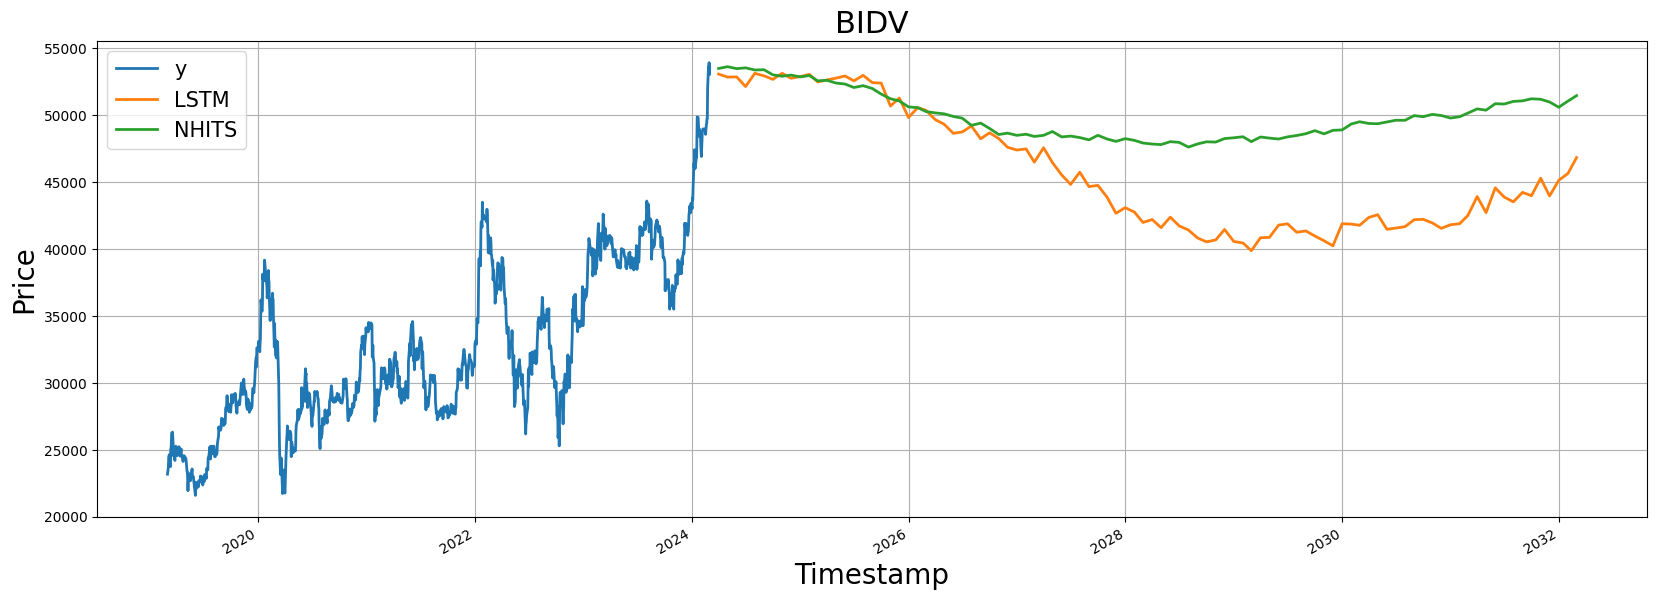

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('BIDV', fontsize=22)
ax.set_ylabel('Price', fontsize=20)
ax.set_xlabel('Timestamp', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()